In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchaudio
import torch
import numpy as np
import pandas as pd
import os
import pickle
import re
import torchaudio.transforms as T
import math
import librosa
import librosa.display
import matplotlib.patches as patches
from glob import glob
import util
from util import audio_file
from util import *
from Losses import FocalLoss,WeightedFocalLoss
from StackedLSTM2 import StackedLSTM
from AttentionLSTM import Attention_LSTM
from Toy_Model import ToyModel
import time
import parselmouth
torch.manual_seed(1)

input_list, labels_list = load_data_limit(6)
n_samples = input_list.size()[0]
train_split = 4*n_samples//5
test_samples = n_samples - train_split
test_input_list = input_list[train_split:]
test_labels_list = labels_list[train_split:]
input_list = input_list[:train_split]
labels_list = labels_list[:train_split]
input_list.shape
print("done")

0
(180600,)
1
(180600,)
2
(180600,)
3
(180600,)
4
(180600,)
5
(180600,)
6
done


In [2]:
def load_model(model_name = 'Attention'):
    if model_name == "Attention":
        model_path = '/project/graziul/ra/ajays/lang-of-pol/vad/Attention_model/model_weights.pt'
        model = Attention_LSTM()
    elif model_name == "LSTM":
        model_path = '/project/graziul/ra/ajays/lang-of-pol/vad/LSTM_layer_model/model_weights.pt'
        model = ToyModel()
    elif model_name == "Speechbrain":
        pass
    #odel_weights = torch.load(model.state_dict(), model_path)
    model.load_state_dict(torch.load(model_path))
    return model

def convert_to_s(transcritions, frame_length = 25, frame_skip = 10):
    #transcriptions is the frame level transcriptions, to convert to a list of intervals in seconds
    num_frames = np.array(transcriptions).shape[0]
    num_ms = frame_skip*num_frames + frame_length
    ms_seconds_arr = np.zeros(num_frames*frame_length)
    i = 0
    while(1):
        if(i >= num_frames):
            break
        else:
            frame_num = i//frame_skip #lies in this frame for sure
            frame_idx = i - 10*frame_num
            temp = transcriptions[frame_num] + transcriptions[frame_num - 1]
            if frame_idx < 5:
                temp = temp+transcriptions[frame_num - 2]
                
            if temp >= 1:
                ms_seconds_arr[i] = 1
            else:
                ms_seconds_arr[i] = 0
                
    #We have the ms seconds array, now convert to list of intervals
    start = 0
    transcripts_list = []
    start_idx = 0
    end_idx = 0
    for i in range(ms_seconds_arr):
        if(start == 0 and ms_seconds_arr[i] == 1):
            start_idx = i
            start = 1
        elif(start == 1 and ms_seconds_arr[1] == 0):
            end_idx = i-1
            start = 0
            transcripts_list.append([start_idx,end_idx])
    return transcripts_list

class postprocessing():
    def __init__(self, model, inputs_list, labels_list, transcriptions = None):
        self.model = model
        self.inputs_list = inputs_list
        self.true_labels = labels_list
        if self.model:
            self.batch_size = self.model.batch_size
            self.transcriptions = torch.round(get_predictions(self.model, self.inputs_list, self.true_labels, self.batch_size)).numpy()    
        else:
            self.transcriptions = transcriptions
    
    def add_pred(self, x,true_label=None):
        with torch.no_grad():
            y = self.model(torch.transpose(x,1,2)).numpy()
        self.transcriptions = np.concatenate([self.transcriptions,y], axis = 0)
        return y
    
    def get_comm_lengths(self):
        #Communication lengths in frames
        final_comms_list = []
        for i in range(self.transcriptions.shape[0]):
            comms_list = []
            start_flag = 0
            end_flag = 0
            run = 0
            for j in range(self.transcriptions.shape[1]):
                if start_flag == 0 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    start_flag = 1
                    run = 1
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 1:
                    run = run +1
                    if j == self.transcriptions.shape[1] - 1:
                            comms_list.append(run)
                elif start_flag == 1 and end_flag == 0 and self.transcriptions[i][j] == 0:
                    comms_list.append(run)
                    start_flag = 0
                    run  = 0
        
            final_comms_list.append(comms_list)
        return final_comms_list
        
    def plot_transcripts(self,label = None):
        plt.plot(label)
        plt.imshow()
        return
    
    def get_comm_stats(self):
        comms = self.get_comm_lengths()
        for i in range(len(comms)):
            if len(comms[i]) != 0:
                df = pd.DataFrame(np.array(comms[i]))
                #print(df.describe())
            else:
                #comms.append([5])
                pass
        comms_combined = sum(comms,[])
        df = pd.DataFrame(np.array(comms_combined))
        print(df.describe())
        plt.hist(comms_combined, bins = 40)
        return comms_combined
    
    def get_frequencies(self,axis = 1):
        final_freq_list = []
        freq_list = []
        comm_prev= 0
        comm_end = 0
        start_flag = 0
        for j in range(np.concatenate(post_processor.transcriptions, axis = 0).shape[0]):
            if start_flag == 0 and np.concatenate(post_processor.transcriptions, axis = 0)[j] == 1:
                comm_end = j
                start_flag = 1
                if comm_end != comm_prev:
                    freq_list.append(comm_end - comm_prev)
                comm_prev= comm_end

            elif start_flag == 1 and np.concatenate(post_processor.transcriptions, axis = 0)[j] == 0:
                start_flag = 0
        df = pd.DataFrame(freq_list)
        print(df.describe())
        plt.hist(freq_list, bins = 50)
        return freq_list

model = load_model()
post_processor = postprocessing(model, test_input_list, test_labels_list)

180
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179


                0
count  385.000000
mean    64.085714
std     76.269570
min      1.000000
25%     15.000000
50%     34.000000
75%     88.000000
max    455.000000


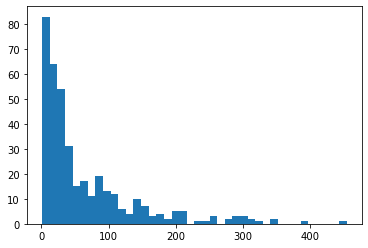

In [22]:
comm = post_processor.get_comm_stats()
#freq = post_processor.get_frequencies()

(array([75., 90., 55., 41., 36., 21.,  8.,  9.,  6.,  7.,  6.,  1.,  2.,
         0.,  2.,  1.,  0.,  0.,  0.,  3.,  1.,  2.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([   4.  ,   41.88,   79.76,  117.64,  155.52,  193.4 ,  231.28,
         269.16,  307.04,  344.92,  382.8 ,  420.68,  458.56,  496.44,
         534.32,  572.2 ,  610.08,  647.96,  685.84,  723.72,  761.6 ,
         799.48,  837.36,  875.24,  913.12,  951.  ,  988.88, 1026.76,
        1064.64, 1102.52, 1140.4 , 1178.28, 1216.16, 1254.04, 1291.92,
        1329.8 , 1367.68, 1405.56, 1443.44, 1481.32, 1519.2 , 1557.08,
        1594.96, 1632.84, 1670.72, 1708.6 , 1746.48, 1784.36, 1822.24,
        1860.12, 1898.  ]),
 <BarContainer object of 50 artists>)

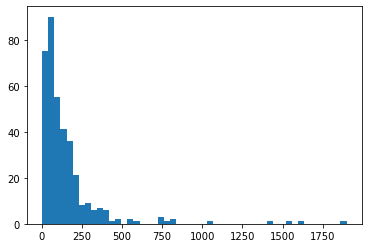

In [18]:
plt.hist(np.array(freq)[np.nonzero(np.array(freq) < 2000)], bins = 50)

(array([74., 55., 40., 39., 24., 15., 11., 11., 10., 15.,  9., 10.,  7.,
         6.,  3.,  9.,  6.,  4.,  3.,  2.,  2.,  1.,  9.,  0.,  0.,  0.,
         1.,  1.,  3.,  0.,  2.,  3.,  2.,  1.,  2.,  1.,  0.,  2.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  1.  ,  10.08,  19.16,  28.24,  37.32,  46.4 ,  55.48,  64.56,
         73.64,  82.72,  91.8 , 100.88, 109.96, 119.04, 128.12, 137.2 ,
        146.28, 155.36, 164.44, 173.52, 182.6 , 191.68, 200.76, 209.84,
        218.92, 228.  , 237.08, 246.16, 255.24, 264.32, 273.4 , 282.48,
        291.56, 300.64, 309.72, 318.8 , 327.88, 336.96, 346.04, 355.12,
        364.2 , 373.28, 382.36, 391.44, 400.52, 409.6 , 418.68, 427.76,
        436.84, 445.92, 455.  ]),
 <BarContainer object of 50 artists>)

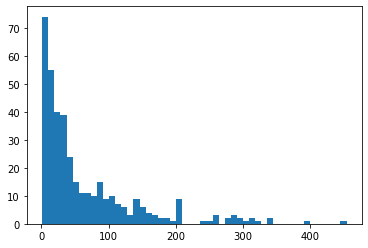

In [30]:
plt.hist(np.array(comm)[np.nonzero(np.array(comm) < 500)], bins = 50)

In [3]:
pkl_path = '/project/graziul/ra/ajays/whitelisted_vad_dict.pkl'
file = open(pkl_path,'rb')
vad_dict = pickle.load(file)
file.close()

for idx,key in enumerate(vad_dict):
        print(idx)
        if idx > 0:
            break
        a = audio_file(key)
        a.get_slices(vad_dict)
        x = a.get_split_mfcc()
        a.get_split_frames()
        y = a.get_split_labels()

0
(180600,)
1


In [ ]:
#Load from whitelisted.csv
datapath = '/project/graziul/data/whitelisted_vad_files.csv'
dataframe = pd.read_csv(datapath, header=None)

transcripts_path = '/project/graziul/transcripts/transcripts2021_10_27.csv'
transcripts_df = pd.read_csv(transcripts_path)
df_groups = transcripts_df.groupby(['zone','day','month','year','file'])
#clean_transcripts_df_files = [process_filename(transcripts_file) for transcripts_file in list(transcripts_df['file'])]
#print(clean_transcripts_df_files)

new_filename_list = []
chars_to_remove = ['_','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','.']
for idx,elt in enumerate(list(dataframe[0])):
    my_elt = process_filename(elt)
    new_filename_list.append(my_elt[:-1] + '.mp3')
    #new_filename_list.append(my_elt[:-1])
new_filename_list = list(set(new_filename_list))


In [4]:
print(torch.transpose(x,1,2).size())

torch.Size([300, 602, 40])


In [ ]:
y = post_processor.model(torch.transpose(x,1,2)).numpy()

In [ ]:
aud,sr = torchaudio.load(key)
aud = torch.squeeze(aud)
librosa.display.waveshow(aud.numpy())
post_processor.plot_transcripts(post_processor.add_pred(x,None))